In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

dataset = torchvision.datasets.DTD(root="data", download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 625M/625M [00:34<00:00, 18.1MB/s]


In [3]:
print(f"Total images: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print("classes:")
for i, cls in enumerate(dataset.classes[:len(dataset.classes)]):
  print(f"[{i}] {cls}")

Total images: 1880
Number of classes: 47
classes:
[0] banded
[1] blotchy
[2] braided
[3] bubbly
[4] bumpy
[5] chequered
[6] cobwebbed
[7] cracked
[8] crosshatched
[9] crystalline
[10] dotted
[11] fibrous
[12] flecked
[13] freckled
[14] frilly
[15] gauzy
[16] grid
[17] grooved
[18] honeycombed
[19] interlaced
[20] knitted
[21] lacelike
[22] lined
[23] marbled
[24] matted
[25] meshed
[26] paisley
[27] perforated
[28] pitted
[29] pleated
[30] polka-dotted
[31] porous
[32] potholed
[33] scaly
[34] smeared
[35] spiralled
[36] sprinkled
[37] stained
[38] stratified
[39] striped
[40] studded
[41] swirly
[42] veined
[43] waffled
[44] woven
[45] wrinkled
[46] zigzagged


In [4]:
import os
data_dir = "data/dtd/dtd/images"
# Collect all image paths
image_paths = []
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))

print(f"Total images found: {len(image_paths)}")

Total images found: 5641


In [5]:
all_class_names = sorted({os.path.basename(os.path.dirname(p)) for p in image_paths})
class_to_idx = {cls: i for i, cls in enumerate(all_class_names)}
num_classes = len(all_class_names)
print(f"Total classes found: {num_classes}")

Total classes found: 47


In [6]:
import numpy as np
rng = np.random.default_rng(seed=42)
rng.shuffle(image_paths)

In [7]:
train_split = int(0.6 * len(image_paths))
val_split = int(0.8 * len(image_paths))
train_paths = image_paths[:train_split]
val_paths = image_paths[train_split:val_split]
test_paths = image_paths[val_split:]
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

Train: 3384, Val: 1128, Test: 1129


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image, UnidentifiedImageError
import os
import random

torch.random.manual_seed(42)
random.seed(42)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class DTDTextureDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, train=True):
        self.image_paths = image_paths
        self.class_to_idx = class_to_idx
        self.train = train

        if train:
            self.transform = T.Compose(
                [
                    T.Resize((256, 256)),
                    T.RandomResizedCrop(224, scale=(0.7, 1.0)),
                    T.RandomHorizontalFlip(),
                    T.ColorJitter(
                        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
                    ),
                    T.ToTensor(),
                    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ]
            )
        else:
            self.transform = T.Compose(
                [
                    T.Resize((256, 256)),
                    T.CenterCrop(224),
                    T.ToTensor(),
                    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ]
            )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except (UnidentifiedImageError, OSError):
            img = Image.new("RGB", (224, 224))

        class_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx[class_name]

        img = self.transform(img)
        return img, label


In [9]:
train_dataset = DTDTextureDataset(train_paths, class_to_idx, train=True)
val_dataset = DTDTextureDataset(val_paths, class_to_idx, train=False)
test_dataset = DTDTextureDataset(test_paths, class_to_idx, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 14
Number of batches in val_loader: 5
Number of batches in test_loader: 5


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 47):
        super().__init__()
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1_1   = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2   = nn.BatchNorm2d(32)

        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn2_1   = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2   = nn.BatchNorm2d(64)

        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2)
        self.bn3_1   = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=2, dilation=2)
        self.bn3_2   = nn.BatchNorm2d(128)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.5)
        self.fc      = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = SimpleCNN(num_classes=num_classes)
print("SimpleCNN model")

SimpleCNN model


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)

print(f"Model moved to: {device}")

Model moved to: cuda


In [12]:
from tqdm.notebook import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 200

print("Starting training...")

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    # Training
    model.train()
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / total_train_samples
    epoch_train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_accuracy = correct_val_predictions / total_val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(
        f"Epoch {epoch+1}/{num_epochs}:\t"
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}\t"
        f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}"
    )

print("Training complete!")

Starting training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/200:	Train Loss: 3.8722, Train Acc: 0.0331	Val Loss: 5.1298, Val Acc: 0.0417


Training Epoch 2:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/200:	Train Loss: 3.7557, Train Acc: 0.0550	Val Loss: 3.7337, Val Acc: 0.0514


Training Epoch 3:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/200:	Train Loss: 3.6829, Train Acc: 0.0724	Val Loss: 3.6471, Val Acc: 0.0842


Training Epoch 4:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/200:	Train Loss: 3.6405, Train Acc: 0.0830	Val Loss: 3.6807, Val Acc: 0.0780


Training Epoch 5:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/200:	Train Loss: 3.6132, Train Acc: 0.0913	Val Loss: 3.5653, Val Acc: 0.0913


Training Epoch 6:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/200:	Train Loss: 3.5467, Train Acc: 0.0937	Val Loss: 3.5905, Val Acc: 0.0762


Training Epoch 7:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/200:	Train Loss: 3.5244, Train Acc: 0.1037	Val Loss: 3.5303, Val Acc: 0.1020


Training Epoch 8:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/200:	Train Loss: 3.4871, Train Acc: 0.1114	Val Loss: 3.5187, Val Acc: 0.1020


Training Epoch 9:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/200:	Train Loss: 3.4744, Train Acc: 0.1144	Val Loss: 3.4666, Val Acc: 0.1161


Training Epoch 10:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/200:	Train Loss: 3.4686, Train Acc: 0.1200	Val Loss: 3.4975, Val Acc: 0.0949


Training Epoch 11:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/200:	Train Loss: 3.4466, Train Acc: 0.1161	Val Loss: 3.4317, Val Acc: 0.1108


Training Epoch 12:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/200:	Train Loss: 3.4118, Train Acc: 0.1297	Val Loss: 3.3917, Val Acc: 0.1365


Training Epoch 13:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/200:	Train Loss: 3.4024, Train Acc: 0.1182	Val Loss: 3.4304, Val Acc: 0.1206


Training Epoch 14:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/200:	Train Loss: 3.3911, Train Acc: 0.1280	Val Loss: 3.3639, Val Acc: 0.1303


Training Epoch 15:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/200:	Train Loss: 3.3482, Train Acc: 0.1291	Val Loss: 3.3978, Val Acc: 0.1339


Training Epoch 16:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/200:	Train Loss: 3.3327, Train Acc: 0.1353	Val Loss: 3.5319, Val Acc: 0.1055


Training Epoch 17:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/200:	Train Loss: 3.3691, Train Acc: 0.1238	Val Loss: 3.4206, Val Acc: 0.1064


Training Epoch 18:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/200:	Train Loss: 3.3415, Train Acc: 0.1380	Val Loss: 3.4383, Val Acc: 0.1073


Training Epoch 19:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/200:	Train Loss: 3.3347, Train Acc: 0.1362	Val Loss: 3.3279, Val Acc: 0.1339


Training Epoch 20:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/200:	Train Loss: 3.3164, Train Acc: 0.1404	Val Loss: 3.3976, Val Acc: 0.1232


Training Epoch 21:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/200:	Train Loss: 3.2963, Train Acc: 0.1501	Val Loss: 3.4584, Val Acc: 0.1117


Training Epoch 22:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/200:	Train Loss: 3.3020, Train Acc: 0.1448	Val Loss: 3.3404, Val Acc: 0.1268


Training Epoch 23:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/200:	Train Loss: 3.2958, Train Acc: 0.1442	Val Loss: 3.2864, Val Acc: 0.1676


Training Epoch 24:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/200:	Train Loss: 3.2672, Train Acc: 0.1531	Val Loss: 3.2643, Val Acc: 0.1622


Training Epoch 25:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/200:	Train Loss: 3.2313, Train Acc: 0.1572	Val Loss: 3.2097, Val Acc: 0.1738


Training Epoch 26:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/200:	Train Loss: 3.2214, Train Acc: 0.1605	Val Loss: 3.2624, Val Acc: 0.1525


Training Epoch 27:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/200:	Train Loss: 3.2292, Train Acc: 0.1596	Val Loss: 3.3337, Val Acc: 0.1543


Training Epoch 28:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/200:	Train Loss: 3.2155, Train Acc: 0.1696	Val Loss: 3.1933, Val Acc: 0.1720


Training Epoch 29:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/200:	Train Loss: 3.1762, Train Acc: 0.1735	Val Loss: 3.2860, Val Acc: 0.1587


Training Epoch 30:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/200:	Train Loss: 3.1540, Train Acc: 0.1717	Val Loss: 3.1587, Val Acc: 0.1755


Training Epoch 31:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/200:	Train Loss: 3.1285, Train Acc: 0.1743	Val Loss: 3.1659, Val Acc: 0.1746


Training Epoch 32:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/200:	Train Loss: 3.1128, Train Acc: 0.1711	Val Loss: 3.1915, Val Acc: 0.1915


Training Epoch 33:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/200:	Train Loss: 3.1026, Train Acc: 0.1865	Val Loss: 3.1363, Val Acc: 0.1817


Training Epoch 34:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/200:	Train Loss: 3.0622, Train Acc: 0.1939	Val Loss: 3.2415, Val Acc: 0.1782


Training Epoch 35:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/200:	Train Loss: 3.0565, Train Acc: 0.1885	Val Loss: 3.1532, Val Acc: 0.1738


Training Epoch 36:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/200:	Train Loss: 3.0270, Train Acc: 0.1891	Val Loss: 3.0585, Val Acc: 0.2092


Training Epoch 37:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/200:	Train Loss: 3.0341, Train Acc: 0.1947	Val Loss: 3.1690, Val Acc: 0.1826


Training Epoch 38:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/200:	Train Loss: 3.0087, Train Acc: 0.1974	Val Loss: 3.0975, Val Acc: 0.1835


Training Epoch 39:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/200:	Train Loss: 3.0055, Train Acc: 0.1974	Val Loss: 3.1242, Val Acc: 0.1684


Training Epoch 40:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/200:	Train Loss: 2.9788, Train Acc: 0.2066	Val Loss: 3.0596, Val Acc: 0.1888


Training Epoch 41:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/200:	Train Loss: 2.9759, Train Acc: 0.2145	Val Loss: 3.1237, Val Acc: 0.1888


Training Epoch 42:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/200:	Train Loss: 2.9545, Train Acc: 0.2083	Val Loss: 3.1342, Val Acc: 0.1950


Training Epoch 43:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/200:	Train Loss: 2.9327, Train Acc: 0.2128	Val Loss: 2.9598, Val Acc: 0.2367


Training Epoch 44:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/200:	Train Loss: 2.9061, Train Acc: 0.2293	Val Loss: 2.9522, Val Acc: 0.2402


Training Epoch 45:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/200:	Train Loss: 2.8759, Train Acc: 0.2329	Val Loss: 2.9662, Val Acc: 0.2225


Training Epoch 46:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/200:	Train Loss: 2.8678, Train Acc: 0.2335	Val Loss: 2.9973, Val Acc: 0.2216


Training Epoch 47:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/200:	Train Loss: 2.8589, Train Acc: 0.2370	Val Loss: 2.9573, Val Acc: 0.2074


Training Epoch 48:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/200:	Train Loss: 2.8291, Train Acc: 0.2447	Val Loss: 3.0097, Val Acc: 0.2225


Training Epoch 49:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/200:	Train Loss: 2.8713, Train Acc: 0.2311	Val Loss: 2.9304, Val Acc: 0.2562


Training Epoch 50:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/200:	Train Loss: 2.8227, Train Acc: 0.2367	Val Loss: 2.8762, Val Acc: 0.2491


Training Epoch 51:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 51:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/200:	Train Loss: 2.7770, Train Acc: 0.2565	Val Loss: 2.9621, Val Acc: 0.2332


Training Epoch 52:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 52:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/200:	Train Loss: 2.7980, Train Acc: 0.2562	Val Loss: 3.0671, Val Acc: 0.2199


Training Epoch 53:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 53:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/200:	Train Loss: 2.7942, Train Acc: 0.2491	Val Loss: 2.8794, Val Acc: 0.2323


Training Epoch 54:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 54:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/200:	Train Loss: 2.7425, Train Acc: 0.2491	Val Loss: 2.9269, Val Acc: 0.2402


Training Epoch 55:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 55:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/200:	Train Loss: 2.7201, Train Acc: 0.2680	Val Loss: 2.8778, Val Acc: 0.2491


Training Epoch 56:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 56:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/200:	Train Loss: 2.7149, Train Acc: 0.2633	Val Loss: 2.7814, Val Acc: 0.2598


Training Epoch 57:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 57:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/200:	Train Loss: 2.6434, Train Acc: 0.2858	Val Loss: 2.8419, Val Acc: 0.2633


Training Epoch 58:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 58:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/200:	Train Loss: 2.6569, Train Acc: 0.2840	Val Loss: 2.9223, Val Acc: 0.2234


Training Epoch 59:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 59:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/200:	Train Loss: 2.6467, Train Acc: 0.2831	Val Loss: 2.7794, Val Acc: 0.2571


Training Epoch 60:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 60:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/200:	Train Loss: 2.6056, Train Acc: 0.2996	Val Loss: 2.6953, Val Acc: 0.2881


Training Epoch 61:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 61:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/200:	Train Loss: 2.5940, Train Acc: 0.2937	Val Loss: 2.8171, Val Acc: 0.2881


Training Epoch 62:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 62:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/200:	Train Loss: 2.5766, Train Acc: 0.2905	Val Loss: 2.8766, Val Acc: 0.2651


Training Epoch 63:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 63:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/200:	Train Loss: 2.5654, Train Acc: 0.2937	Val Loss: 2.6778, Val Acc: 0.2757


Training Epoch 64:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 64:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/200:	Train Loss: 2.5260, Train Acc: 0.2999	Val Loss: 2.7789, Val Acc: 0.2819


Training Epoch 65:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 65:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/200:	Train Loss: 2.5112, Train Acc: 0.3073	Val Loss: 2.8487, Val Acc: 0.2615


Training Epoch 66:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 66:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/200:	Train Loss: 2.4814, Train Acc: 0.3254	Val Loss: 2.7802, Val Acc: 0.2553


Training Epoch 67:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 67:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/200:	Train Loss: 2.4864, Train Acc: 0.3159	Val Loss: 2.8139, Val Acc: 0.2793


Training Epoch 68:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 68:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/200:	Train Loss: 2.5760, Train Acc: 0.2973	Val Loss: 2.6978, Val Acc: 0.2961


Training Epoch 69:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 69:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69/200:	Train Loss: 2.5190, Train Acc: 0.3118	Val Loss: 2.6789, Val Acc: 0.3094


Training Epoch 70:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 70:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70/200:	Train Loss: 2.4421, Train Acc: 0.3378	Val Loss: 2.6231, Val Acc: 0.3121


Training Epoch 71:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 71:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71/200:	Train Loss: 2.4211, Train Acc: 0.3310	Val Loss: 2.6499, Val Acc: 0.2863


Training Epoch 72:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 72:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72/200:	Train Loss: 2.3818, Train Acc: 0.3404	Val Loss: 2.5976, Val Acc: 0.3546


Training Epoch 73:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 73:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73/200:	Train Loss: 2.3791, Train Acc: 0.3466	Val Loss: 2.7506, Val Acc: 0.2872


Training Epoch 74:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 74:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74/200:	Train Loss: 2.3696, Train Acc: 0.3478	Val Loss: 2.6889, Val Acc: 0.3200


Training Epoch 75:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 75:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75/200:	Train Loss: 2.3600, Train Acc: 0.3502	Val Loss: 2.7424, Val Acc: 0.2970


Training Epoch 76:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 76:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76/200:	Train Loss: 2.3719, Train Acc: 0.3401	Val Loss: 2.6110, Val Acc: 0.3129


Training Epoch 77:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 77:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77/200:	Train Loss: 2.3465, Train Acc: 0.3543	Val Loss: 2.7421, Val Acc: 0.2704


Training Epoch 78:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 78:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78/200:	Train Loss: 2.3407, Train Acc: 0.3599	Val Loss: 2.5028, Val Acc: 0.3652


Training Epoch 79:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 79:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79/200:	Train Loss: 2.3274, Train Acc: 0.3522	Val Loss: 2.5281, Val Acc: 0.3289


Training Epoch 80:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 80:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80/200:	Train Loss: 2.2855, Train Acc: 0.3706	Val Loss: 2.6429, Val Acc: 0.3067


Training Epoch 81:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 81:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81/200:	Train Loss: 2.2685, Train Acc: 0.3676	Val Loss: 2.6583, Val Acc: 0.3067


Training Epoch 82:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 82:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82/200:	Train Loss: 2.2329, Train Acc: 0.3886	Val Loss: 2.5703, Val Acc: 0.3342


Training Epoch 83:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 83:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83/200:	Train Loss: 2.2452, Train Acc: 0.3744	Val Loss: 2.5832, Val Acc: 0.3342


Training Epoch 84:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 84:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84/200:	Train Loss: 2.2508, Train Acc: 0.3762	Val Loss: 2.7080, Val Acc: 0.2979


Training Epoch 85:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 85:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85/200:	Train Loss: 2.2927, Train Acc: 0.3567	Val Loss: 2.8826, Val Acc: 0.2837


Training Epoch 86:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 86:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86/200:	Train Loss: 2.2753, Train Acc: 0.3661	Val Loss: 2.5735, Val Acc: 0.3342


Training Epoch 87:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 87:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87/200:	Train Loss: 2.1910, Train Acc: 0.3842	Val Loss: 2.5411, Val Acc: 0.3333


Training Epoch 88:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 88:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88/200:	Train Loss: 2.1972, Train Acc: 0.3871	Val Loss: 2.5540, Val Acc: 0.3369


Training Epoch 89:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 89:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89/200:	Train Loss: 2.2078, Train Acc: 0.3850	Val Loss: 2.6871, Val Acc: 0.2961


Training Epoch 90:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 90:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90/200:	Train Loss: 2.1603, Train Acc: 0.4025	Val Loss: 2.5724, Val Acc: 0.3271


Training Epoch 91:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 91:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91/200:	Train Loss: 2.1875, Train Acc: 0.3889	Val Loss: 2.7787, Val Acc: 0.2943


Training Epoch 92:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 92:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92/200:	Train Loss: 2.1590, Train Acc: 0.3898	Val Loss: 2.4708, Val Acc: 0.3688


Training Epoch 93:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 93:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93/200:	Train Loss: 2.1435, Train Acc: 0.3995	Val Loss: 2.5168, Val Acc: 0.3324


Training Epoch 94:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 94:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94/200:	Train Loss: 2.1273, Train Acc: 0.3989	Val Loss: 2.5724, Val Acc: 0.3271


Training Epoch 95:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 95:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95/200:	Train Loss: 2.1321, Train Acc: 0.4034	Val Loss: 2.4940, Val Acc: 0.3298


Training Epoch 96:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 96:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96/200:	Train Loss: 2.1314, Train Acc: 0.4040	Val Loss: 2.4608, Val Acc: 0.3599


Training Epoch 97:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 97:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97/200:	Train Loss: 2.1006, Train Acc: 0.4087	Val Loss: 2.3596, Val Acc: 0.3679


Training Epoch 98:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 98:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98/200:	Train Loss: 2.0605, Train Acc: 0.4202	Val Loss: 2.7115, Val Acc: 0.3050


Training Epoch 99:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 99:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99/200:	Train Loss: 2.1110, Train Acc: 0.3960	Val Loss: 2.4868, Val Acc: 0.3484


Training Epoch 100:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100/200:	Train Loss: 2.0933, Train Acc: 0.4090	Val Loss: 2.5054, Val Acc: 0.3378


Training Epoch 101:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 101:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101/200:	Train Loss: 2.0591, Train Acc: 0.4217	Val Loss: 2.5842, Val Acc: 0.3298


Training Epoch 102:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 102:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102/200:	Train Loss: 2.0885, Train Acc: 0.4181	Val Loss: 2.3827, Val Acc: 0.3644


Training Epoch 103:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 103:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103/200:	Train Loss: 2.0692, Train Acc: 0.4196	Val Loss: 2.3484, Val Acc: 0.3848


Training Epoch 104:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 104:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104/200:	Train Loss: 2.0500, Train Acc: 0.4208	Val Loss: 2.6070, Val Acc: 0.3351


Training Epoch 105:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 105:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105/200:	Train Loss: 2.0114, Train Acc: 0.4317	Val Loss: 2.3785, Val Acc: 0.3892


Training Epoch 106:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 106:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106/200:	Train Loss: 1.9775, Train Acc: 0.4409	Val Loss: 2.5123, Val Acc: 0.3413


Training Epoch 107:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 107:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107/200:	Train Loss: 2.0299, Train Acc: 0.4294	Val Loss: 2.5099, Val Acc: 0.3573


Training Epoch 108:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 108:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108/200:	Train Loss: 2.0226, Train Acc: 0.4226	Val Loss: 2.3524, Val Acc: 0.4025


Training Epoch 109:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 109:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109/200:	Train Loss: 2.0647, Train Acc: 0.4111	Val Loss: 2.3904, Val Acc: 0.3608


Training Epoch 110:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 110:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110/200:	Train Loss: 2.0098, Train Acc: 0.4294	Val Loss: 2.4425, Val Acc: 0.3661


Training Epoch 111:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 111:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111/200:	Train Loss: 1.9822, Train Acc: 0.4332	Val Loss: 2.2931, Val Acc: 0.3954


Training Epoch 112:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 112:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112/200:	Train Loss: 2.0074, Train Acc: 0.4350	Val Loss: 2.3270, Val Acc: 0.3803


Training Epoch 113:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 113:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113/200:	Train Loss: 1.9648, Train Acc: 0.4314	Val Loss: 2.2864, Val Acc: 0.3927


Training Epoch 114:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 114:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114/200:	Train Loss: 1.9593, Train Acc: 0.4486	Val Loss: 2.5487, Val Acc: 0.3573


Training Epoch 115:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 115:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115/200:	Train Loss: 1.9394, Train Acc: 0.4433	Val Loss: 2.3654, Val Acc: 0.3972


Training Epoch 116:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 116:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116/200:	Train Loss: 1.9662, Train Acc: 0.4456	Val Loss: 2.3528, Val Acc: 0.3732


Training Epoch 117:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 117:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117/200:	Train Loss: 1.9780, Train Acc: 0.4371	Val Loss: 2.3850, Val Acc: 0.3688


Training Epoch 118:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 118:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118/200:	Train Loss: 2.0117, Train Acc: 0.4341	Val Loss: 2.5359, Val Acc: 0.3502


Training Epoch 119:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 119:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119/200:	Train Loss: 2.0198, Train Acc: 0.4187	Val Loss: 2.5378, Val Acc: 0.3484


Training Epoch 120:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 120:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120/200:	Train Loss: 1.9491, Train Acc: 0.4376	Val Loss: 2.3441, Val Acc: 0.3821


Training Epoch 121:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 121:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121/200:	Train Loss: 1.9352, Train Acc: 0.4456	Val Loss: 2.3511, Val Acc: 0.3874


Training Epoch 122:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 122:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122/200:	Train Loss: 1.8995, Train Acc: 0.4557	Val Loss: 2.4382, Val Acc: 0.3644


Training Epoch 123:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 123:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123/200:	Train Loss: 1.9212, Train Acc: 0.4577	Val Loss: 2.3276, Val Acc: 0.4069


Training Epoch 124:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 124:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124/200:	Train Loss: 1.9056, Train Acc: 0.4622	Val Loss: 2.9665, Val Acc: 0.3262


Training Epoch 125:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 125:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125/200:	Train Loss: 1.9493, Train Acc: 0.4477	Val Loss: 2.2776, Val Acc: 0.4051


Training Epoch 126:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 126:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126/200:	Train Loss: 1.8999, Train Acc: 0.4607	Val Loss: 2.3478, Val Acc: 0.3848


Training Epoch 127:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 127:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127/200:	Train Loss: 1.9201, Train Acc: 0.4439	Val Loss: 2.3105, Val Acc: 0.3972


Training Epoch 128:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 128:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128/200:	Train Loss: 1.8769, Train Acc: 0.4699	Val Loss: 2.2916, Val Acc: 0.3980


Training Epoch 129:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 129:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129/200:	Train Loss: 1.8850, Train Acc: 0.4681	Val Loss: 2.2590, Val Acc: 0.4176


Training Epoch 130:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 130:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130/200:	Train Loss: 1.8377, Train Acc: 0.4778	Val Loss: 2.3113, Val Acc: 0.3821


Training Epoch 131:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 131:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131/200:	Train Loss: 1.8502, Train Acc: 0.4737	Val Loss: 2.4483, Val Acc: 0.3652


Training Epoch 132:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 132:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132/200:	Train Loss: 1.8898, Train Acc: 0.4637	Val Loss: 2.8503, Val Acc: 0.3138


Training Epoch 133:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 133:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133/200:	Train Loss: 1.9064, Train Acc: 0.4524	Val Loss: 2.3659, Val Acc: 0.3706


Training Epoch 134:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 134:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134/200:	Train Loss: 1.8753, Train Acc: 0.4719	Val Loss: 2.3957, Val Acc: 0.3670


Training Epoch 135:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 135:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135/200:	Train Loss: 1.8943, Train Acc: 0.4539	Val Loss: 2.3298, Val Acc: 0.3945


Training Epoch 136:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 136:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136/200:	Train Loss: 1.8885, Train Acc: 0.4563	Val Loss: 2.4950, Val Acc: 0.3449


Training Epoch 137:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 137:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137/200:	Train Loss: 1.8780, Train Acc: 0.4642	Val Loss: 2.5632, Val Acc: 0.3404


Training Epoch 138:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 138:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138/200:	Train Loss: 1.8566, Train Acc: 0.4675	Val Loss: 2.4669, Val Acc: 0.3688


Training Epoch 139:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 139:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139/200:	Train Loss: 1.8659, Train Acc: 0.4687	Val Loss: 2.2541, Val Acc: 0.4105


Training Epoch 140:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 140:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140/200:	Train Loss: 1.7915, Train Acc: 0.4891	Val Loss: 2.2897, Val Acc: 0.3874


Training Epoch 141:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 141:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141/200:	Train Loss: 1.8257, Train Acc: 0.4790	Val Loss: 2.5227, Val Acc: 0.3697


Training Epoch 142:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 142:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142/200:	Train Loss: 1.9007, Train Acc: 0.4554	Val Loss: 2.4047, Val Acc: 0.3732


Training Epoch 143:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 143:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143/200:	Train Loss: 1.8462, Train Acc: 0.4648	Val Loss: 2.2100, Val Acc: 0.4113


Training Epoch 144:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 144:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144/200:	Train Loss: 1.8066, Train Acc: 0.4808	Val Loss: 2.5454, Val Acc: 0.3670


Training Epoch 145:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 145:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145/200:	Train Loss: 1.7795, Train Acc: 0.4823	Val Loss: 2.3980, Val Acc: 0.4025


Training Epoch 146:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 146:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146/200:	Train Loss: 1.8152, Train Acc: 0.4835	Val Loss: 2.4615, Val Acc: 0.3759


Training Epoch 147:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 147:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147/200:	Train Loss: 1.8458, Train Acc: 0.4710	Val Loss: 2.6061, Val Acc: 0.3715


Training Epoch 148:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 148:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148/200:	Train Loss: 1.8044, Train Acc: 0.4796	Val Loss: 2.2388, Val Acc: 0.4282


Training Epoch 149:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 149:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149/200:	Train Loss: 1.8184, Train Acc: 0.4837	Val Loss: 2.3460, Val Acc: 0.3848


Training Epoch 150:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150/200:	Train Loss: 1.7617, Train Acc: 0.4905	Val Loss: 2.4659, Val Acc: 0.3670


Training Epoch 151:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 151:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151/200:	Train Loss: 1.7993, Train Acc: 0.4770	Val Loss: 2.2567, Val Acc: 0.4105


Training Epoch 152:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 152:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152/200:	Train Loss: 1.8444, Train Acc: 0.4740	Val Loss: 3.1689, Val Acc: 0.3005


Training Epoch 153:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 153:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153/200:	Train Loss: 1.8522, Train Acc: 0.4761	Val Loss: 2.2562, Val Acc: 0.4184


Training Epoch 154:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 154:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154/200:	Train Loss: 1.7970, Train Acc: 0.4817	Val Loss: 2.3599, Val Acc: 0.3848


Training Epoch 155:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 155:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155/200:	Train Loss: 1.8027, Train Acc: 0.4672	Val Loss: 2.4597, Val Acc: 0.3715


Training Epoch 156:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 156:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156/200:	Train Loss: 1.7809, Train Acc: 0.4885	Val Loss: 2.4214, Val Acc: 0.3856


Training Epoch 157:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 157:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157/200:	Train Loss: 1.7549, Train Acc: 0.4870	Val Loss: 2.3087, Val Acc: 0.3989


Training Epoch 158:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 158:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158/200:	Train Loss: 1.8228, Train Acc: 0.4835	Val Loss: 2.2073, Val Acc: 0.4273


Training Epoch 159:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 159:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159/200:	Train Loss: 1.7609, Train Acc: 0.4962	Val Loss: 2.2219, Val Acc: 0.4184


Training Epoch 160:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 160:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160/200:	Train Loss: 1.7380, Train Acc: 0.5092	Val Loss: 2.2826, Val Acc: 0.4291


Training Epoch 161:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 161:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161/200:	Train Loss: 1.8121, Train Acc: 0.4752	Val Loss: 2.2858, Val Acc: 0.3874


Training Epoch 162:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 162:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162/200:	Train Loss: 1.7601, Train Acc: 0.4935	Val Loss: 2.2546, Val Acc: 0.4202


Training Epoch 163:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 163:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163/200:	Train Loss: 1.7758, Train Acc: 0.4867	Val Loss: 2.2873, Val Acc: 0.4025


Training Epoch 164:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 164:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164/200:	Train Loss: 1.7691, Train Acc: 0.4882	Val Loss: 2.3091, Val Acc: 0.4282


Training Epoch 165:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 165:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165/200:	Train Loss: 1.7536, Train Acc: 0.4905	Val Loss: 2.2982, Val Acc: 0.3892


Training Epoch 166:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 166:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166/200:	Train Loss: 1.7552, Train Acc: 0.4997	Val Loss: 2.4076, Val Acc: 0.3918


Training Epoch 167:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 167:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167/200:	Train Loss: 1.8622, Train Acc: 0.4719	Val Loss: 2.4011, Val Acc: 0.3910


Training Epoch 168:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 168:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168/200:	Train Loss: 1.7990, Train Acc: 0.4811	Val Loss: 2.3500, Val Acc: 0.3954


Training Epoch 169:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 169:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169/200:	Train Loss: 1.8067, Train Acc: 0.4790	Val Loss: 2.4710, Val Acc: 0.3883


Training Epoch 170:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 170:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170/200:	Train Loss: 1.7821, Train Acc: 0.4852	Val Loss: 2.1919, Val Acc: 0.4379


Training Epoch 171:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 171:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171/200:	Train Loss: 1.7332, Train Acc: 0.4944	Val Loss: 2.5233, Val Acc: 0.3803


Training Epoch 172:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 172:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172/200:	Train Loss: 1.7299, Train Acc: 0.5056	Val Loss: 2.3321, Val Acc: 0.4300


Training Epoch 173:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 173:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173/200:	Train Loss: 1.6872, Train Acc: 0.5157	Val Loss: 2.2293, Val Acc: 0.4060


Training Epoch 174:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 174:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174/200:	Train Loss: 1.7123, Train Acc: 0.5148	Val Loss: 2.4592, Val Acc: 0.3715


Training Epoch 175:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 175:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175/200:	Train Loss: 1.6691, Train Acc: 0.5145	Val Loss: 2.2537, Val Acc: 0.4238


Training Epoch 176:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 176:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176/200:	Train Loss: 1.6830, Train Acc: 0.5098	Val Loss: 2.3198, Val Acc: 0.3892


Training Epoch 177:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 177:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177/200:	Train Loss: 1.7044, Train Acc: 0.5148	Val Loss: 2.4586, Val Acc: 0.3803


Training Epoch 178:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 178:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178/200:	Train Loss: 1.6977, Train Acc: 0.5021	Val Loss: 2.2800, Val Acc: 0.4264


Training Epoch 179:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 179:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179/200:	Train Loss: 1.6573, Train Acc: 0.5245	Val Loss: 2.3052, Val Acc: 0.4149


Training Epoch 180:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 180:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180/200:	Train Loss: 1.7045, Train Acc: 0.5033	Val Loss: 2.3463, Val Acc: 0.3927


Training Epoch 181:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 181:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181/200:	Train Loss: 1.7203, Train Acc: 0.4962	Val Loss: 2.2959, Val Acc: 0.4105


Training Epoch 182:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 182:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182/200:	Train Loss: 1.6469, Train Acc: 0.5186	Val Loss: 2.3930, Val Acc: 0.4069


Training Epoch 183:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 183:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183/200:	Train Loss: 1.6810, Train Acc: 0.5254	Val Loss: 2.4900, Val Acc: 0.3883


Training Epoch 184:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 184:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184/200:	Train Loss: 1.6704, Train Acc: 0.5210	Val Loss: 2.1867, Val Acc: 0.4477


Training Epoch 185:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 185:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185/200:	Train Loss: 1.6655, Train Acc: 0.5100	Val Loss: 2.3986, Val Acc: 0.3936


Training Epoch 186:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 186:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186/200:	Train Loss: 1.7014, Train Acc: 0.5077	Val Loss: 2.4042, Val Acc: 0.4193


Training Epoch 187:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 187:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187/200:	Train Loss: 1.7032, Train Acc: 0.5100	Val Loss: 2.2682, Val Acc: 0.4388


Training Epoch 188:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 188:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188/200:	Train Loss: 1.6712, Train Acc: 0.5171	Val Loss: 2.3293, Val Acc: 0.4087


Training Epoch 189:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 189:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189/200:	Train Loss: 1.6894, Train Acc: 0.5086	Val Loss: 2.3208, Val Acc: 0.4060


Training Epoch 190:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 190:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190/200:	Train Loss: 1.6662, Train Acc: 0.5157	Val Loss: 2.3117, Val Acc: 0.4353


Training Epoch 191:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 191:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191/200:	Train Loss: 1.6725, Train Acc: 0.5115	Val Loss: 2.2508, Val Acc: 0.4184


Training Epoch 192:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 192:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192/200:	Train Loss: 1.6640, Train Acc: 0.5174	Val Loss: 2.2258, Val Acc: 0.4255


Training Epoch 193:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 193:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193/200:	Train Loss: 1.6603, Train Acc: 0.5148	Val Loss: 2.5885, Val Acc: 0.3777


Training Epoch 194:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 194:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194/200:	Train Loss: 1.7056, Train Acc: 0.5077	Val Loss: 2.3728, Val Acc: 0.4246


Training Epoch 195:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 195:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195/200:	Train Loss: 1.6690, Train Acc: 0.5139	Val Loss: 2.2979, Val Acc: 0.4096


Training Epoch 196:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 196:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196/200:	Train Loss: 1.7223, Train Acc: 0.5071	Val Loss: 2.2883, Val Acc: 0.4193


Training Epoch 197:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 197:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197/200:	Train Loss: 1.6719, Train Acc: 0.5183	Val Loss: 2.2632, Val Acc: 0.4406


Training Epoch 198:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 198:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198/200:	Train Loss: 1.6716, Train Acc: 0.5148	Val Loss: 2.3558, Val Acc: 0.4113


Training Epoch 199:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 199:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199/200:	Train Loss: 1.6748, Train Acc: 0.5177	Val Loss: 2.2115, Val Acc: 0.4495


Training Epoch 200:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Epoch 200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200/200:	Train Loss: 1.6778, Train Acc: 0.5124	Val Loss: 2.2292, Val Acc: 0.4051
Training complete!


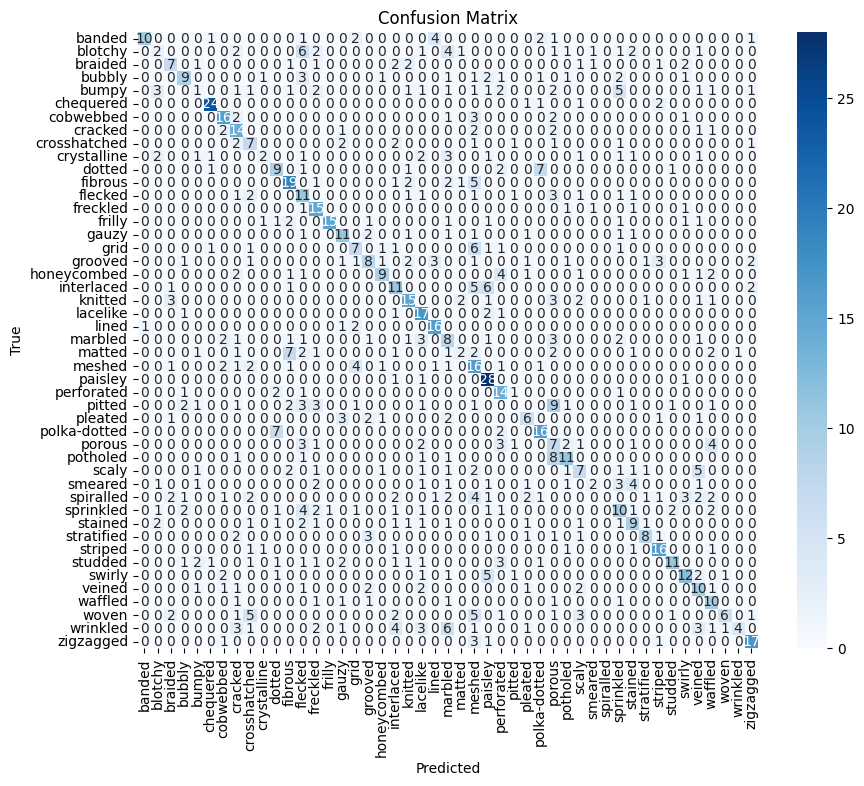

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_class_names, yticklabels=all_class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [14]:
# Accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.4296
Precision: 0.4446
Recall: 0.4296
F1-score: 0.4086


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


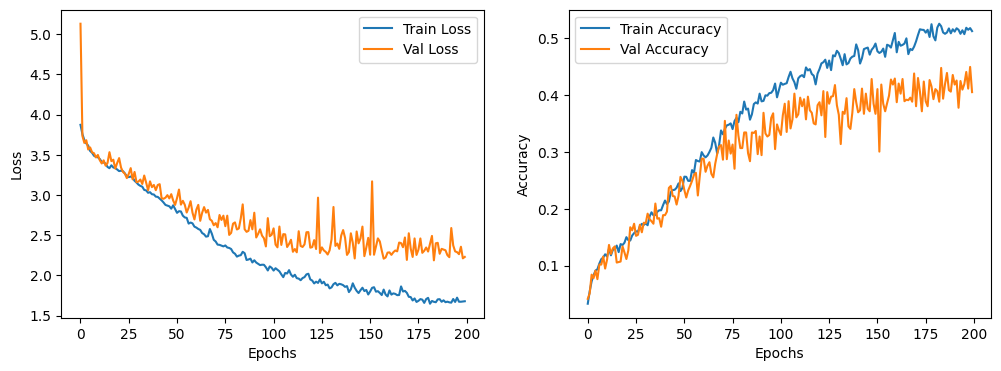

In [15]:
# Graph the losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/dtd_model3.pth')
# print("Model saved to /content/drive/MyDrive/dtd_model.pth")

Model saved to /content/drive/MyDrive/dtd_model.pth


In [18]:
# Save the model
torch.save(model.state_dict(), 'dtd_model3.pth')
print("Model saved to dtd_model3.pth")

Model saved to dtd_model3.pth
